In [0]:
import tensorflow as tf
sess = tf.InteractiveSession()
import numpy as np
import matplotlib.pyplot as plt
batch_size = 64

In [0]:
def generator (z):
  with tf.variable_scope("generator", reuse = tf.AUTO_REUSE), tf.device('/gpu:0'):
    mat = tf.Variable(tf.random_normal(shape = [100, 4 * 4 * 1024], stddev = 0.02))
    bias = tf.Variable(tf.constant(0.0, tf.float32, shape = [4 * 4 * 1024]))
    x = tf.matmul(z, mat) + bias
    x = tf.reshape(x, [batch_size,4,4,1024])
    x = tf.layers.batch_normalization(x, momentum = 0.9, epsilon = 1e-5, training = True)
    x = tf.nn.relu(x)
    filter1 = tf.Variable(tf.random_normal(shape = [5,5,512,1024], stddev = 0.02))
    bias1 = tf.Variable(tf.constant(0.0, tf.float32, shape = [512]))
    x = tf.nn.conv2d_transpose(x, filter1, [batch_size,8,8,512], [1,2,2,1], padding = 'SAME')
    x = tf.reshape(tf.nn.bias_add(x, bias1), [batch_size,8,8,512])
    x = tf.layers.batch_normalization(x, momentum = 0.9, epsilon = 1e-5, training = True)
    x = tf.nn.relu(x)
    filter2 = tf.Variable(tf.random_normal(shape = [5,5,256,512], stddev = 0.02))
    bias2 = tf.Variable(tf.constant(0.0, tf.float32, shape = [256]))
    x = tf.nn.conv2d_transpose(x, filter2, [batch_size,16,16,256], [1,2,2,1], padding = 'SAME')
    x = tf.reshape(tf.nn.bias_add(x, bias2), [batch_size,16,16,256])
    x = tf.layers.batch_normalization(x, momentum = 0.9, epsilon = 1e-5, training = True)
    x = tf.nn.relu(x)
    filter3 = tf.Variable(tf.random_normal(shape = [5,5,128,256], stddev = 0.02))
    bias3 = tf.Variable(tf.constant(0.0, tf.float32, shape = [128]))
    x = tf.nn.conv2d_transpose(x, filter3, [batch_size,32,32,128], [1,2,2,1], padding = 'SAME')
    x = tf.reshape(tf.nn.bias_add(x, bias3), [batch_size,32,32,128])
    x = tf.layers.batch_normalization(x, momentum = 0.9, epsilon = 1e-5, training = True)
    x = tf.nn.relu(x)
    filter4 = tf.Variable(tf.random_normal(shape = [5,5,1,128], stddev = 0.02))
    bias4 = tf.Variable(tf.constant(0.0, tf.float32, shape = [1]))
    x = tf.nn.conv2d_transpose(x, filter4, [batch_size,64,64,1], [1,2,2,1], padding = 'SAME')
    x = tf.reshape(tf.nn.bias_add(x, bias4), [batch_size,64,64,1])
    x = tf.nn.tanh(x)
    return x

In [0]:
def leakyrelu (x, factor = 0.2):
  return tf.maximum(factor * x, x)

In [0]:
def discriminator(image):
  with tf.variable_scope("discriminator", reuse = tf.AUTO_REUSE), tf.device('/gpu:0'):
    filter1 = tf.Variable(tf.random_normal(shape = [5,5,1, 64], stddev = 0.02))
    bias1 = tf.Variable(tf.constant(0.0, tf.float32, shape = [64]))
    x = tf.nn.conv2d(image, filter1, strides = [1,2,2,1], padding = 'SAME')
    x = tf.reshape(tf.nn.bias_add(x, bias1), [batch_size,32,32,64])
    x = leakyrelu(x)
    filter2 = tf.Variable(tf.random_normal(shape = [5,5,64,128], stddev = 0.02))
    bias2 = tf.Variable(tf.constant(0.0, tf.float32, shape = [128]))
    x = tf.nn.conv2d(x, filter2, strides = [1,2,2,1], padding = 'SAME')
    x = tf.reshape(tf.nn.bias_add(x, bias2), [batch_size, 16, 16, 128])
    x = tf.layers.batch_normalization(x, momentum = 0.9, epsilon = 1e-5, training = True)
    x = leakyrelu(x)
    filter3 = tf.Variable(tf.random_normal(shape = [5, 5, 128, 256], stddev = 0.02))
    bias3 = tf.Variable(tf.constant(0.0, tf.float32, shape = [256]))
    x = tf.nn.conv2d(x, filter3, strides = [1,2,2,1], padding = 'SAME')
    x = tf.reshape(tf.nn.bias_add(x, bias3), [batch_size, 8, 8, 256])
    x = tf.layers.batch_normalization(x, momentum = 0.9, epsilon = 1e-5, training = True)
    x = leakyrelu(x)
    filter4 = tf.Variable(tf.random_normal(shape = [5, 5, 256, 512], stddev = 0.02))
    bias4 = tf.Variable(tf.constant(0.0, tf.float32, shape = [512]))
    x = tf.nn.conv2d(x, filter4, strides = [1, 2, 2, 1], padding = 'SAME')
    x = tf.reshape(tf.nn.bias_add(x, bias4), [batch_size, 4, 4, 512])
    x = tf.layers.batch_normalization(x, momentum = 0.9, epsilon = 1e-5, training = True)
    x = leakyrelu(x)
    w1 = tf.Variable(tf.random_normal(shape = [4 * 4 * 512, 1], stddev = 0.02))
    b1 = tf.Variable(tf.constant(0.0, tf.float32, shape = [1]))
    x = tf.matmul(tf.reshape(x, [batch_size, 4 * 4 * 512]), w1) + b1
    return tf.nn.sigmoid(x), x

In [0]:
def sample_Z(shape):
  return np.random.uniform(-1., 1., size=shape)

In [0]:
z_placeholder = tf.placeholder(tf.float32, [batch_size, 100])
X = tf.placeholder(tf.float32, [batch_size, 64, 64, 1])

In [0]:
G_sample = generator(z_placeholder)
D_real, D_real_logits = discriminator(X)
D_fake, D_fake_logits = discriminator(G_sample)

#D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_real_logits, labels = tf.ones_like(D_real) * (1)))
#D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_fake_logits, labels = tf.zeros_like(D_fake)))
#D_loss = D_loss_real + D_loss_fake
#G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_fake_logits, labels = tf.ones_like(D_fake)))

#D_loss = -tf.reduce_mean(tf.log(D_real) - tf.log(D_fake))
#G_loss = -tf.reduce_mean(tf.log(D_fake))

D_loss = -tf.reduce_mean(tf.log(D_real)+tf.log(1-D_fake))
G_loss = -tf.reduce_mean(tf.log(D_fake))

In [0]:
d_vars = [var for var in tf.trainable_variables() if 'discriminator' in var.name]
g_vars = [var for var in tf.trainable_variables() if 'generator' in var.name]

In [0]:
D_optim = tf.train.AdamOptimizer(learning_rate = 0.0002, beta1 = 0.5).minimize(D_loss, var_list = d_vars)
G_optim = tf.train.AdamOptimizer(learning_rate = 0.0002, beta1 = 0.5).minimize(G_loss, var_list = g_vars)

In [0]:
init = tf.global_variables_initializer()
sess.run(init)

In [11]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=[])
train_set = tf.image.resize_images(mnist.train.images, [64, 64]).eval()
train_set = (train_set - 0.5) / 0.5

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


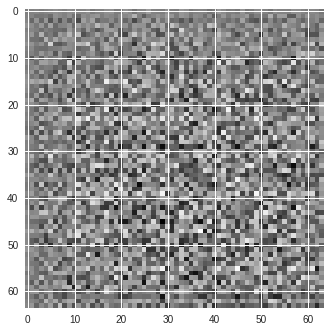

Iter: 0
D loss: 2.022
G_loss: 9.474

Iter: 100
D loss: 1.011
G_loss: 19.78

Iter: 200
D loss: 0.9475
G_loss: 5.908

Iter: 300
D loss: 0.7202
G_loss: 16.15

Iter: 400
D loss: 0.7202
G_loss: 3.478

Iter: 500
D loss: 0.7483
G_loss: 10.8

Iter: 600
D loss: 0.7483
G_loss: 5.891

Iter: 700
D loss: 0.7483
G_loss: 3.737

Iter: 800
D loss: 0.7483
G_loss: 2.777



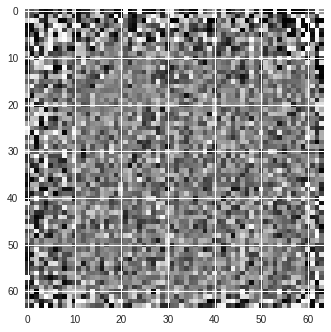

Epoch: 1 completed


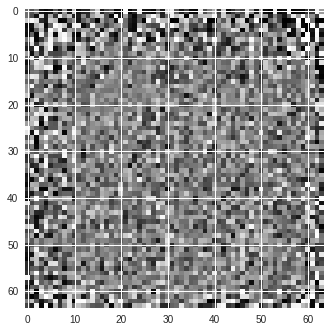

Iter: 0
D loss: 0.7483
G_loss: 2.098

Iter: 100
D loss: 0.7483
G_loss: 1.469

Iter: 200
D loss: 0.7483
G_loss: 0.804

Iter: 300
D loss: 0.7201
G_loss: 13.51

Iter: 400
D loss: 0.7201
G_loss: 9.899

Iter: 500
D loss: 0.7201
G_loss: 8.654

Iter: 600
D loss: 0.7201
G_loss: 6.948

Iter: 700
D loss: 0.7201
G_loss: 6.11

Iter: 800
D loss: 0.7201
G_loss: 5.599



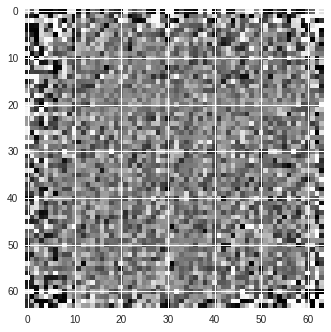

Epoch: 2 completed


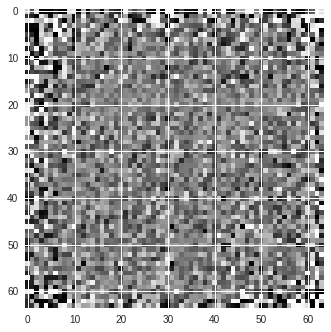

Iter: 0
D loss: 0.7201
G_loss: 5.452

Iter: 100
D loss: 0.7201
G_loss: 5.428

Iter: 200
D loss: 0.7201
G_loss: 4.964

Iter: 300
D loss: 0.7201
G_loss: 4.52

Iter: 400
D loss: 0.7201
G_loss: 3.958

Iter: 500
D loss: 0.7201
G_loss: 4.091

Iter: 600
D loss: 0.7201
G_loss: 3.738

Iter: 700
D loss: 0.7201
G_loss: 3.703

Iter: 800
D loss: 0.7201
G_loss: 3.339



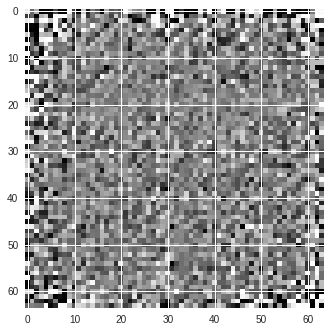

Epoch: 3 completed


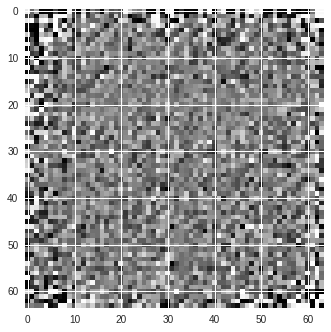

Iter: 0
D loss: 0.7201
G_loss: 3.518



In [0]:
#D_loss_curr = sess.run(D_loss, feed_dict={X: train_set[np.random.choice(train_set.shape[0], batch_size, replace=False), :], z_placeholder: sample_Z([batch_size, 100])})

for epoch in range(200):
  for it in range(858):
      
      if it % 857 == 0:
          samples = sess.run(G_sample, feed_dict={z_placeholder: sample_Z([batch_size, 100])})
          plt.imshow(np.reshape(samples[0], (64, 64)), cmap='gray')
          plt.show()

      X_mb = train_set[it * 64 : (it + 1) * 64]

      #D_loss_fake_curr = sess.run(D_loss_fake, feed_dict={z_placeholder: sample_Z([batch_size, 100])})
      #D_loss_real_curr = sess.run(D_loss_real, feed_dict={X: X_mb, z_placeholder: sample_Z([batch_size, 100])})
      D_loss_fake_curr = sess.run(tf.reduce_mean(D_fake), feed_dict={z_placeholder: sample_Z([batch_size, 100])})
      if D_loss_fake_curr > 0.5: 
        _, D_loss_curr = sess.run([D_optim, D_loss], feed_dict={X: X_mb, z_placeholder: sample_Z([batch_size, 100])})
      _, G_loss_curr = sess.run([G_optim, G_loss], feed_dict={z_placeholder: sample_Z([batch_size, 100])})
      #_, G_loss_curr = sess.run([G_optim, G_loss], feed_dict={z_placeholder: sample_Z([batch_size, 100])})
      

      if it % 100 == 0:
          print('Iter: {}'.format(it))
          print('D loss: {:.4}'. format(D_loss_curr))
          #print('D loss real: ' + str(D_loss_real_curr))
          #print('D loss fake: ' + str(D_loss_fake_curr))
          print('G_loss: {:.4}'.format(G_loss_curr))
          print()
  print("Epoch: " + str(epoch + 1) + " completed")